In [2]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train_dir = '/kaggle/input/tomato/n_train'  # Path to the training dataset
validation_dir = '/kaggle/input/tomato/n_val'  # Path to the validation dataset
test_dr = "/kaggle/input/tomato/n_test"

In [28]:
img_width, img_height = 256, 256
batch_size = 32

# Create data generators with data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
b=1.3
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
a = 1.8
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)
test_generator = train_datagen.flow_from_directory(
    test_dr,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 11105 images belonging to 6 classes.
Found 2495 images belonging to 6 classes.
Found 280 images belonging to 6 classes.


In [5]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [6]:
for layer in base_model.layers:
    layer.trainable = False


In [7]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(train_generator.num_classes, activation='softmax'))


In [8]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
from keras.callbacks import ReduceLROnPlateau
model.compile(optimizer='adam',loss = 'categorical_crossentropy',metrics=['accuracy'])
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=25,  # Adjust the number of epochs based on your needs
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping]
)

Epoch 1/25
347/347 [==============================] - 221s 609ms/step - loss: 0.7104 - accuracy: 0.8131 - val_loss: 0.3129 - val_accuracy: 0.8896
Epoch 2/25
347/347 [==============================] - 162s 467ms/step - loss: 14.2121 - accuracy: 0.9059 - val_loss: 2.2925 - val_accuracy: 0.6745
Epoch 3/25
347/347 [==============================] - 160s 461ms/step - loss: 24.2616 - accuracy: 0.8061 - val_loss: 0.5229 - val_accuracy: 0.8713
Epoch 4/25
347/347 [==============================] - 162s 467ms/step - loss: 59.0447 - accuracy: 0.7761 - val_loss: 0.3657 - val_accuracy: 0.9014


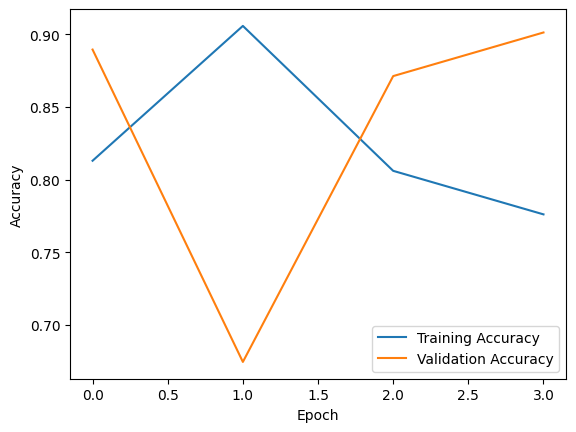

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
model.save('VGG16.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
import matplotlib.pyplot as plt

# Predict classes for the validation set
y_true = test_generator.classes
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)

9/9 [==============================] - 8s 875ms/step


In [29]:
true_positives = np.sum((y_pred == 1) & (y_true == 1))
false_positives = np.sum((y_pred == 1) & (y_true == 0))
false_negatives = np.sum((y_pred == 0) & (y_true == 1))
true_negatives = np.sum((y_pred == 0) & (y_true == 0))

# Calculate Accuracy
accuracy = (true_positives + true_negatives) / (true_positives + false_positives + false_negatives + true_negatives + 1e-9)

# Calculate Precision
precision = true_positives / (true_positives + false_positives + 1e-9)

# Calculate Recall
recall = true_positives / (true_positives + false_negatives + 1e-9)

# Calculate F1 Score
f1_score = 2 * (precision * recall) / (precision + recall + 1e-9)

# Print the results
print("Dense_Net_Accuracy: {:.2%}".format(accuracy))
print("Dense_Net_Precision: {:.2%}".format(precision))
print("Dense_Net_Recall: {:.2%}".format(recall))
print("Dense_Net_F1 Score: {:.2%}".format(f1_score))

Dense_Net_Accuracy: 97.50%
Dense_Net_Precision: 83.57%
Dense_Net_Recall: 90.00%
Dense_Net_F1 Score: 86.67%


1/1 [==============================] - 0s 146ms/step
Predicted Class: 1


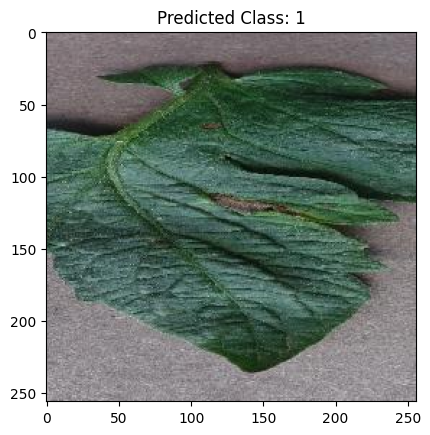

Predicted disease: Tomato_Early Blight


In [31]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt  # Add this import statement


test_image_path = '/kaggle/input/tomato/n_test/Tomato_Early Blight/072ae43a-416b-434a-a5a2-1b48bc47fada___RS_Erly.B 7472_flipTB.JPG'
img = load_img(test_image_path, target_size=(img_width, img_height))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize pixel values

# Make a prediction for the single image
prediction = model.predict(img_array)

# Convert prediction to class label
predicted_class = np.argmax(prediction)
print(f'Predicted Class: {predicted_class}')

# Visualize the image
plt.imshow(img)
plt.title(f'Predicted Class: {predicted_class}')
plt.show()

class_labels = {0: 'Tomato_Bacterial Spot', 1: 'Tomato_Early Blight', 2: 'Tomato_Healthy', 3: 'Tomato_Late Blight', 4: 'Tomato_Septoria Leaf Spot', 5: 'Tomato_Yellow Leaf Curl Virus'}  # Replace with your actual class names

# Print the predicted disease
predicted_disease = class_labels.get(predicted_class, 'Unknown Disease')
print("Predicted disease:", predicted_disease)

1/1 [==============================] - 0s 20ms/step
Predicted Class: 1


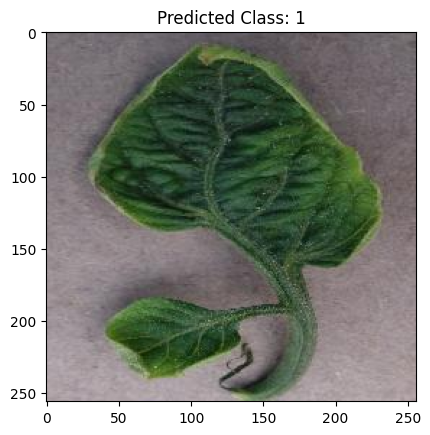

Predicted disease: Tomato_Early Blight


In [33]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt  # Add this import statement

test_image_path = '/kaggle/input/tomato/n_test/Tomato_Yellow Leaf Curl Virus/9300962c-fa16-4c51-b18c-bd0022434680___YLCV_GCREC 2484.JPG'
img = load_img(test_image_path, target_size=(img_width, img_height))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize pixel values

# Make a prediction for the single image
prediction = model.predict(img_array)

# Convert prediction to class label
predicted_class = np.argmax(prediction)
print(f'Predicted Class: {predicted_class}')

# Visualize the image
plt.imshow(img)
plt.title(f'Predicted Class: {predicted_class}')
plt.show()

class_labels = {0: 'Tomato_Bacterial Spot', 1: 'Tomato_Early Blight', 2: 'Tomato_Healthy', 3: 'Tomato_Late Blight', 4: 'Tomato_Septoria Leaf Spot', 5: 'Tomato_Yellow Leaf Curl Virus'}  # Replace with your actual class names

# Print the predicted disease
predicted_disease = class_labels.get(predicted_class, 'Unknown Disease')
print("Predicted disease:", predicted_disease)